# Non-hierarchical pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the values of L, $\theta$, and $a_g$ for each individual pendulum.

Compare this to the results from the same dataset with a hierarchical setup (different notebook).

In [2]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
import arviz as az
import corner

## Non-hierarchical setup first

In [51]:
# First do this without sigma

'''
# Eight Schools example
J = 8

... def eight_schools(J, sigma, y=None):

...     mu = numpyro.sample('mu', dist.Normal(0, 5))

...     tau = numpyro.sample('tau', dist.HalfCauchy(5))

...     with numpyro.plate('J', J):

...         theta = numpyro.sample('theta', dist.Normal(mu, tau))
...         numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

'''
# p(a,phi,theta,L|x)
# a is local to a planet
# phi is akin to redshift for the lenses (observable?)
# G is global, target of inference
# a = G * phi ; G constant
# phi = M/r**2
# phi[0], phi[1], phi[2].. phi[8]

def pendulum_pos(N_pendulums, error, y=None):
    
    # specify the sampling distribution using the model parameters
    # plate means assuming data are independent
    with numpyro.plate('N', N_pendulums):
        # these are the priors for parameters we are fitting
        a = numpyro.sample('a_g', dist.Uniform(0,15))
        theta = numpyro.sample('theta', dist.Uniform(0,jnp.pi/2))
        L = numpyro.sample('L', dist.Uniform(0,10))

        # transformed parameters using the deterministic function
        # if necessary
        pos = numpyro.deterministic('pos', L * jnp.sin(theta * jnp.cos(jnp.sqrt(a / L)) * 1))
    
        numpyro.sample('obs', dist.Normal(pos, error), obs=y)



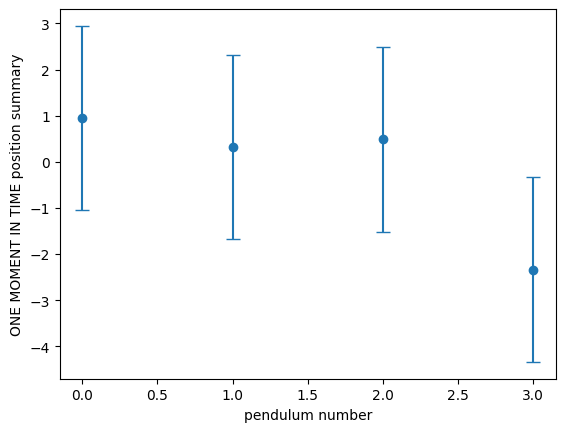

In [56]:
# Construct the data
# four pendulums on each planet
x = [0,1,2,3]#,4,5,6,7]
N_pendulums = 4

# Generate the data
true_Ls = [6, 8,# 10, 12,
           6, 8]#, 10, 12]
true_thetas = [0, jnp.pi/8,#, jnp.pi/4, 3*jnp.pi/4,
               0, jnp.pi/8]#, jnp.pi/4, 3*jnp.pi/4]
true_as = [8, 8,#, 8, 8,
           12, 12]#, 12, 12]
true_params = np.array([true_Ls, true_thetas, true_as])

# For reproducibility, let's set the random number seed and generate the data:
np.random.seed(12)
yerr = 2 * np.ones(np.shape(x))

#y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))

y = true_params[0] * jnp.sin(true_params[1] * jnp.cos(jnp.sqrt(true_params[2] / true_params[0]))) + yerr * np.random.randn(len(x))
#L * jnp.sin(theta * jnp.cos(jnp.sqrt(a / L)) * 1)

#y = np.array([8.0, 8.0, 3.0, 7.0, 1.0, 1.0, 18.0, 12.0])

#sigma = 

plt.errorbar(x, y, yerr = yerr, linestyle = 'None', capsize = 5)
plt.scatter(x, y)
plt.ylabel('ONE MOMENT IN TIME position summary')
plt.xlabel('pendulum number');

[[ 4.2529936  -2.591387    8.416192   -4.9220705 ]
 [ 4.417964    0.29323432  3.7467124  -0.11259373]
 [ 3.324859   -1.1580497   2.7925959  -0.9391105 ]
 ...
 [ 3.1030955  -2.9918132  -0.119709   -1.3636333 ]
 [ 2.4352434   1.5683815   8.640557   -2.7763689 ]
 [-0.05950658  1.0297065   2.373173   -3.1749258 ]] (500, 4)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


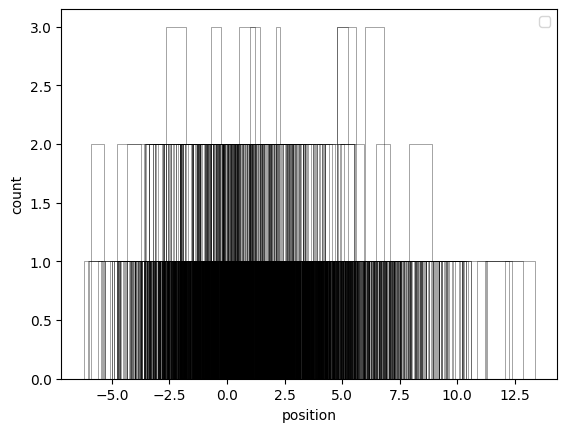

In [57]:
# First check what the prior predictive distribution looks like
# Before running the MCMC
prior_pred = numpyro.infer.Predictive(pendulum_pos, num_samples = 500)(
    random.PRNGKey(1), N_pendulums, yerr
)
print(prior_pred['obs'], np.shape(prior_pred['obs']))

# ...and plot them:
label = "prior samples"
for n in range(len(prior_pred["obs"])):
    plt.hist(
        prior_pred['obs'][n],
        histtype="step",
        color="k",
        lw=0.5,
        alpha=0.5)

#plt.hist(data["parallax"], 120, histtype="step", color="C0", label="data")
plt.legend()
plt.xlabel("position")
plt.ylabel("count");

In [58]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(pendulum_pos),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(random.PRNGKey(0), N_pendulums, yerr, y=y)

/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_76978/3461794701.py:3: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = numpyro.infer.MCMC(
sample: 100%|████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 10416.88it/s, 7 steps of size 4.00e-01. acc. prob=0.89]


CPU times: user 2.52 s, sys: 66.1 ms, total: 2.59 s
Wall time: 2.6 s


In [59]:
inf_data = az.from_numpyro(sampler)
az.summary(inf_data)
#p(L,a,theta|x) joint posterior
#p(L,a,theta,phi|x) also joint posterior across levels

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
L[0]      4.511  2.760   0.000    9.010      0.046    0.033    3259.0   
L[1]      4.182  2.677   0.001    8.799      0.043    0.032    3441.0   
L[2]      4.202  2.714   0.004    8.832      0.041    0.030    4103.0   
L[3]      3.250  2.349   0.000    7.701      0.044    0.040    2832.0   
a_g[0]    7.902  4.268   0.948   14.988      0.063    0.046    4214.0   
a_g[1]    7.976  4.212   1.233   14.982      0.059    0.042    4762.0   
a_g[2]    8.051  4.254   1.172   14.976      0.063    0.045    4195.0   
a_g[3]    9.022  4.107   2.000   14.998      0.063    0.044    4021.0   
pos[0]    0.769  1.304  -1.371    3.401      0.018    0.014    4857.0   
pos[1]    0.539  1.163  -1.491    2.930      0.017    0.013    4832.0   
pos[2]    0.591  1.224  -1.483    3.103      0.018    0.014    4647.0   
pos[3]   -0.129  0.859  -1.808    1.504      0.015    0.010    3368.0   
theta[0]  0.686  0.439   0.000    1.435      0.007    0.006    3770.0   
theta[1]  0.676  0.451   0.003    1.443      0.007    0.005    4063.0   
theta[2]  0.668  0.439   0.000    1.425      0.007    0.005    3761.0   
theta[3]  0.723  0.467   0.000    1.463      0.008    0.005    3231.0   

          ess_tail  r_hat  
L[0]        2116.0    1.0  
L[1]        2105.0    1.0  
L[2]        2647.0    1.0  
L[3]        1637.0    1.0  
a_g[0]      2661.0    1.0  
a_g[1]      2792.0    1.0  
a_g[2]      2535.0    1.0  
a_g[3]      2484.0    1.0  
pos[0]      3511.0    1.0  
pos[1]      3526.0    1.0  
pos[2]      3533.0    1.0  
pos[3]      3558.0    1.0  
theta[0]    2269.0    1.0  
theta[1]    2675.0    1.0  
theta[2]    2665.0    1.0  
theta[3]    2081.0    1.0

In [61]:
# This is the overall sampler
corner.corner(inf_data);

In [41]:
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      L[0]      4.46      2.65      4.37      0.01      8.22   4160.53      1.00
      L[1]      4.07      2.64      3.79      0.00      7.90   4121.58      1.00
      L[2]      7.16      2.05      7.50      4.36     10.00   3684.92      1.00
      L[3]      8.43      1.26      8.71      6.68     10.00   4873.27      1.00
      L[4]      4.74      2.78      4.70      0.02      8.69   4817.82      1.00
      L[5]      3.32      2.31      2.88      0.01      6.73   4057.38      1.00
      L[6]      6.09      2.49      6.40      2.42     10.00   4232.62      1.00
      L[7]      8.98      0.88      9.20      7.77     10.00   5964.78      1.00
    a_g[0]      7.88      4.27      8.04      1.90     14.99   5790.85      1.00
    a_g[1]      8.18      4.17      8.45      2.10     14.92   5838.94      1.00
    a_g[2]      5.86      3.92      5.37      0.02     11.66   4922.13      1.00
    a_g[3]      4.16      3

In [42]:
print(sampler.get_samples()['a_g'])

[[14.068749    9.344424    0.9644659  ... 13.886435    1.6171364
   1.5710981 ]
 [13.566829    5.7804737   0.5558535  ... 11.336882    3.443366
   2.6744258 ]
 [ 0.8468198  11.252968    3.4382198  ...  6.877056    7.6531067
   4.2833233 ]
 ...
 [ 4.6356106  11.3090515   0.39835787 ...  4.805338   14.310468
   0.7477141 ]
 [ 8.455225   14.108084   11.445648   ... 12.279903   14.708537
   3.8847833 ]
 [ 8.294214    6.54883     7.094577   ...  7.8261395   7.72105
   3.372794  ]]


[Array(0.74439514, dtype=float32), Array(0.5215956, dtype=float32), Array(3.9255164, dtype=float32), Array(6.531228, dtype=float32), Array(1.0387791, dtype=float32), Array(-0.09436026, dtype=float32), Array(2.3962178, dtype=float32), Array(7.7954936, dtype=float32)]


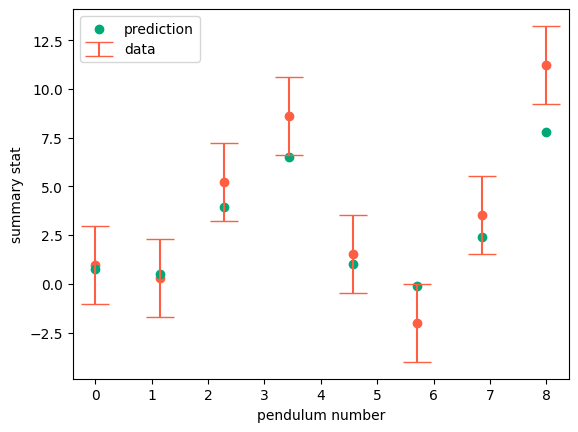

In [46]:
N = N_pendulums
estimates = [np.mean(sampler.get_samples()['pos'][:,i]) for i in range(N_pendulums)]
print(estimates)
plt.clf()
plt.scatter(np.linspace(0,N,N), y, color = '#FE5E41')
plt.errorbar(np.linspace(0,N,N), y, yerr = yerr, linestyle='None',
             capsize = 10, color = '#FE5E41', label = 'data')
#estimates = [np.mean(np.array(mcmc.get_samples()['theta'][x])) for x in np.linspace(0,J,J)]
plt.scatter(np.linspace(0,N,N), estimates, color='#00A878', label = 'prediction')
'''
plt.axhline(y = np.mean(sampler.get_samples()['mu']), color = '#F3C178',
            label = 'overall mean')
plt.axhline(y = np.mean(sampler.get_samples()['mu']) - np.std(mcmc.get_samples()['mu']),
            linestyle='--', color = '#F3C178')
plt.axhline(y = np.mean(sampler.get_samples()['mu']) + np.std(mcmc.get_samples()['mu']),
            linestyle='--', color = '#F3C178')
'''
plt.ylabel('summary stat')
plt.xlabel('pendulum number')
plt.legend()

### Results
Essentially, this is a non-hierarchical model, so the model is not learning from the groups. Instead, it is treating every pendulum individually. This means it does a much poorer job of predicting the position and of predicting the acceleration due to gravity.

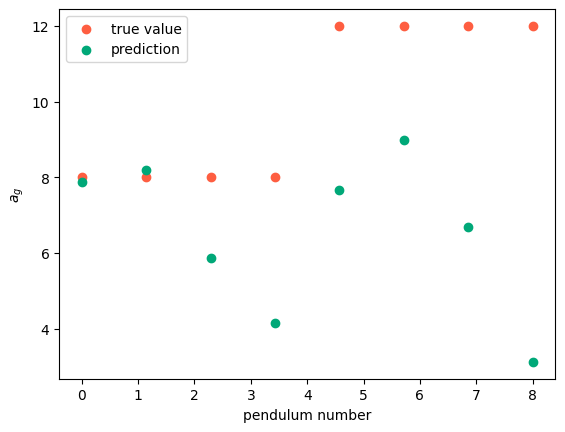

In [49]:
N = N_pendulums
estimates = [np.mean(sampler.get_samples()['a_g'][:,i]) for i in range(N_pendulums)]
plt.clf()
plt.scatter(np.linspace(0,N,N), true_params[2], color = '#FE5E41', label = 'true value')
plt.scatter(np.linspace(0,N,N), estimates, color='#00A878', label = 'prediction')
'''
plt.axhline(y = np.mean(sampler.get_samples()['mu']), color = '#F3C178',
            label = 'overall mean')
plt.axhline(y = np.mean(sampler.get_samples()['mu']) - np.std(mcmc.get_samples()['mu']),
            linestyle='--', color = '#F3C178')
plt.axhline(y = np.mean(sampler.get_samples()['mu']) + np.std(mcmc.get_samples()['mu']),
            linestyle='--', color = '#F3C178')
'''
plt.ylabel('$a_g$')
plt.xlabel('pendulum number')
plt.legend()